# Final Submission

#### loading the libraries

In [17]:

# linear algebra
from sklearn.model_selection import train_test_split
import numpy as np  
# data processing, CSV file I / O (e.g. pd.read_csv)
import pandas as pd  
import os
import tensorflow as tf
from tensorflow.keras.applications.vgg19 import VGG19
from keras.preprocessing.text import Tokenizer
from keras.models import Model
from keras.layers import Flatten, Dense, LSTM, Dropout, Embedding, Activation
from keras.layers import concatenate, BatchNormalization, Input
from keras.utils import to_categorical, plot_model
from keras.applications.inception_v3 import InceptionV3, preprocess_input
import matplotlib.pyplot as plt  # for plotting data
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
np.random.seed(0)
tokenizer = RegexpTokenizer(r'\w+')

In [18]:
def load_description(text):
    mapping = dict()
    for line in text.split("\n"):
        token = line.split(",")
        if len(line) < 2:   # remove short descriptions
            continue
        img_id = token[0].split('.')[0] # name of the image
        img_des = token[1]              # description of the image
        if img_id not in mapping:
            mapping[img_id] = list()
        mapping[img_id].append(img_des)
    return mapping

token_path = f'{os.getcwd()}/captions.txt'
print(token_path)
text = open(token_path, 'r', encoding = 'utf-8').read()
descriptions = load_description(text)
print(descriptions['1000268201_693b08cb0e'])

/Users/ayushagarwal/Desktop/Image_caption/week5/captions.txt
['A child in a pink dress is climbing up a set of stairs in an entry way .', 'A girl going into a wooden building .', 'A little girl climbing into a wooden playhouse .', 'A little girl climbing the stairs to her playhouse .', 'A little girl in a pink dress going into a wooden cabin .']


In [19]:
import re
stopwords = nltk.corpus.stopwords.words('english')
stopwords_lower = [s.lower() for s in stopwords]
def text_preprocessing(str_input): 
     #tokenization, remove punctuation, lemmatization
     words=tokenizer.tokenize(str_input)
     # remove symbols, websites, email addresses 
     words = [re.sub(r'[^A-Za-z@]', ' ', word) for word in words] 
     words = [re.sub(r'\S+com', ' ', word) for word in words]
     words = [re.sub(r'\S+@\S+', ' ', word) for word in words] 
     words = [word for word in words if word!=' ']
     words = [word for word in words if len(word)!=0] 
     #remove stopwords     
     words=[word.lower() for word in words if word.lower() not in stopwords_lower and word.strip() != ""]
     #combine a list into one string   
     string = ' '.join(words)
     return string

In [20]:

def clean_description(desc):
    for key, des_list in desc.items():
        for i in range(len(des_list)):
            caption = des_list[i]
            caption=text_preprocessing(caption)
            des_list[i] = caption
  
clean_description(descriptions)
print(descriptions['1000268201_693b08cb0e'])

['child pink dress climbing set stairs entry way', 'girl going wooden building', 'little girl climbing wooden playhouse', 'little girl climbing stairs playhouse', 'little girl pink dress going wooden cabin']


In [21]:
def to_vocab(desc):
    words = set()
    for key in desc.keys():
        for line in desc[key]:
            words.update(line.split())
    return words
vocab = to_vocab(descriptions)

In [22]:
import glob
images = f'{os.getcwd()}/images/'
# Create a list of all image names in the directory
img = glob.glob(images + '*.jpg')
# train_path = '/kaggle / input / flickr8k / flickr_data / Flickr_Data / Flickr_TextData / Flickr_8k.trainImages.txt'
# train_images = open(train_path, 'r', encoding = 'utf-8').read().split("\n")
train_img = []  # list of all images in training set
for im in img:
    if(im.split('/')[-1].split('.')[0] in list(descriptions.keys())):
        train_img.append(im.split('/')[-1].split('.')[0])
# load descriptions of training set in a dictionary. Name of the image will act as ey
def load_clean_descriptions(des, dataset):
    dataset_des = dict()
    for key, des_list in des.items():
        if key  in dataset:
            if key not in dataset_des:
                dataset_des[key] = list()
            for line in des_list:
                desc = 'startseq ' + line + ' endseq'
                dataset_des[key].append(desc)
    return dataset_des
  
train_descriptions = load_clean_descriptions(descriptions, train_img)
print(train_descriptions['1000268201_693b08cb0e'])

['startseq child pink dress climbing set stairs entry way endseq', 'startseq girl going wooden building endseq', 'startseq little girl climbing wooden playhouse endseq', 'startseq little girl climbing stairs playhouse endseq', 'startseq little girl pink dress going wooden cabin endseq']


In [23]:
from tensorflow.keras.utils import load_img , img_to_array
def preprocess_img(img_path):
    # inception v3 excepts img in 299 * 299 * 3
    img = load_img(img_path, target_size = (224, 224))
    x = img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis = 0)
    x = preprocess_input(x)
    return x
encoding_train=dict()
def encode(image):
    image = preprocess_img(image)
    vec = model.predict(image)
    vec = np.reshape(vec, (vec.shape[1]))
    return vec
  
base_model = VGG19(weights = 'imagenet')
model = Model(base_model.input, base_model.layers[-2].output)
for i in range(len(train_img)):
    print(i)
    encoding_train[train_img[i]] = encode(f'{os.getcwd()}/images/'+train_img[i]+'.jpg')
# run the encode function on all train images and store the feature vectors in a list


0
1/1 [==============================] - 0s 284ms/step
1
1/1 [==============================] - 0s 156ms/step
2
1/1 [==============================] - 0s 173ms/step
3
1/1 [==============================] - 0s 165ms/step
4
1/1 [==============================] - 0s 179ms/step
5
1/1 [==============================] - 0s 172ms/step
6
1/1 [==============================] - 0s 153ms/step
7
1/1 [==============================] - 0s 147ms/step
8
1/1 [==============================] - 0s 148ms/step
9
1/1 [==============================] - 0s 148ms/step
10
1/1 [==============================] - 0s 160ms/step
11
1/1 [==============================] - 0s 172ms/step
12
1/1 [==============================] - 0s 167ms/step
13
1/1 [==============================] - 0s 169ms/step
14
1/1 [==============================] - 0s 201ms/step
15
1/1 [==============================] - 0s 161ms/step
16
1/1 [==============================] - 0s 178ms/step
17
1/1 [==============================] - 0s 150ms/step
18

KeyboardInterrupt: 

In [ ]:
from tensorflow.keras.utils import pad_sequences
# list of all training captions
all_train_captions = []
for key, val in train_descriptions.items():
    for caption in val:
        all_train_captions.append(caption)
  
# consider only words which occur atleast 10 times
vocabulary = vocab
threshold = 10 # you can change this value according to your need
word_counts = {}
for cap in all_train_captions:
    for word in cap.split(' '):
        word_counts[word] = word_counts.get(word, 0) + 1
  
vocab = [word for word in word_counts if word_counts[word] >= threshold]
  
# word mapping to integers
ixtoword = {}
wordtoix = {}
  
ix = 1
for word in vocab:
    wordtoix[word] = ix
    ixtoword[ix] = word
    ix += 1
      
# find the maximum length of a description in a dataset
max_length = max(len(des.split()) for des in all_train_captions)


In [ ]:

encoding_train

{'2387197355_237f6f41ee': array([0.5945173 , 0.        , 0.56817883, ..., 0.45624846, 0.18595651,
        0.367296  ], dtype=float32),
 '2609847254_0ec40c1cce': array([0.7051104 , 0.10699168, 0.57795525, ..., 0.        , 0.7164309 ,
        0.        ], dtype=float32),
 '2046222127_a6f300e202': array([0.31582105, 0.        , 0.5061476 , ..., 0.        , 0.62835735,
        0.01923209], dtype=float32),
 '2853743795_e90ebc669d': array([0.592716  , 0.09590527, 1.1630554 , ..., 0.        , 0.37043443,
        0.        ], dtype=float32),
 '2696951725_e0ae54f6da': array([0.72746885, 0.5091943 , 0.9992198 , ..., 0.        , 0.51675296,
        0.11482322], dtype=float32),
 '3421131122_2e4bde661e': array([0.6397267 , 0.        , 0.4913909 , ..., 0.        , 0.20596217,
        0.17321205], dtype=float32),
 '3229730008_63f8ca2de2': array([0.7336677 , 0.25085717, 0.732125  , ..., 0.        , 0.        ,
        0.        ], dtype=float32),
 '3220009216_10f088185e': array([0.4146988 , 0.        

In [ ]:
vocab_size = len(ixtoword)+1
X1, X2, y = list(), list(), list()
for key, des_list in train_descriptions.items():
	if key not in encoding_train:
		continue
	pic = encoding_train[key]
	for cap in des_list:
		seq = [wordtoix[word] for word in cap.split(' ') if word in wordtoix]
		for i in range(1, len(seq)):
			in_seq, out_seq = seq[:i], seq[i]
			in_seq = pad_sequences([in_seq], maxlen = max_length)[0]
			out_seq = to_categorical([out_seq], num_classes = vocab_size)[0]
			# store
			X1.append(pic)
			X2.append(in_seq)
			y.append(out_seq)

X2 = np.array(X2)
X1 = np.array(X1)
print(X1.shape)
y = np.array(y)

embeddings_index = {}
golve_path =f'{os.getcwd()}/glove.6B.200d.txt'
glove = open(golve_path, 'r', encoding = 'utf-8').read()
for line in glove.split("\n"):
	values = line.split(" ")
	word = values[0]
	indices = np.asarray(values[1: ], dtype = 'float32')
	embeddings_index[word] = indices

emb_dim = 200
emb_matrix = np.zeros((vocab_size, emb_dim))
for word, i in wordtoix.items():
	emb_vec = embeddings_index.get(word)
	if emb_vec is not None and emb_vec.shape[0]!=0:
		print(emb_vec)
		emb_matrix[i] = emb_vec
emb_matrix.shape

(16149, 4096)
[ 0.4934    -0.0085568 -0.4605    -0.34043   -0.54483   -0.28872
 -0.36741    0.24718   -0.34011    0.014366   0.45781    0.36165
  0.7337     0.50021   -0.17436    0.041377   0.20502   -0.026918
  0.037282   0.50586    0.59258    2.7691    -0.19889    0.5653
 -0.2553    -0.45901    0.4568    -0.40661    0.052459   0.070137
  0.059344  -0.052718   0.30277    0.20024    0.34313    0.081758
  0.085739  -0.18318   -0.1859     0.10747   -0.55695   -0.61762
 -0.38464    0.47468   -0.24356    0.26032    0.64833   -0.33619
  0.018929   0.27965    0.1762     0.040914  -0.19203   -0.46665
 -0.063088   0.16165    0.31622    0.21034    0.37293    0.33219
 -0.19701   -0.061427  -0.51818    0.79276   -0.45784   -0.0051152
  0.41883    0.56179   -0.45461    0.084767   0.45429    0.20965
 -0.36056    0.90798   -0.5635     0.0051178 -0.53108    0.45798
  0.6578     0.077957   0.25275    0.6766    -0.92893   -0.2256
  0.41994    0.068108  -0.22972   -0.60866    0.55663   -0.15787
  0.1669

(1832, 200)

In [25]:
from tensorflow.keras.layers import add
# define the model
ip1 = Input(shape = (4096, ))
fe1 = Dropout(0.2)(ip1)
fe2 = Dense(256, activation = 'relu')(fe1)
ip2 = Input(shape = (max_length, ))
se1 = Embedding(vocab_size, emb_dim, mask_zero = True)(ip2)
se2 = Dropout(0.2)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation = 'relu')(decoder1)
outputs = Dense(vocab_size, activation = 'softmax')(decoder2)
model = Model(inputs = [ip1, ip2], outputs = outputs)

In [26]:

model.layers[2].set_weights([emb_matrix])
model.layers[2].trainable = False
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')
model.fit([X1, X2], y, epochs = 5, batch_size = 256)
# you can increase the number of epochs for better results

Epoch 1/5
64/64 [==============================] - 8s 92ms/step - loss: 5.5400
Epoch 2/5
64/64 [==============================] - 6s 92ms/step - loss: 4.8599
Epoch 3/5
64/64 [==============================] - 6s 93ms/step - loss: 4.5130
Epoch 4/5
64/64 [==============================] - 6s 93ms/step - loss: 4.2182
Epoch 5/5
64/64 [==============================] - 6s 91ms/step - loss: 3.9461


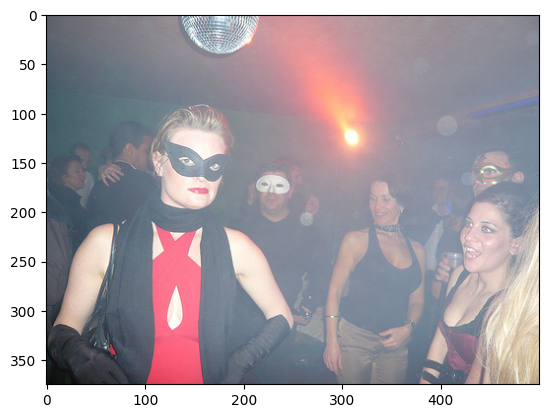

1/1 [==============================] - 0s 16ms/step
Greedy Search: two men standing


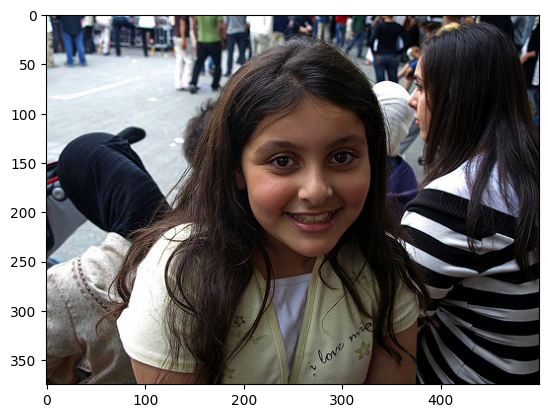

1/1 [==============================] - 0s 12ms/step
Greedy Search: two young girls standing


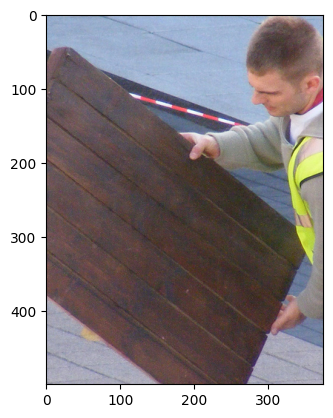

1/1 [==============================] - 0s 13ms/step
Greedy Search: man wearing black shirt


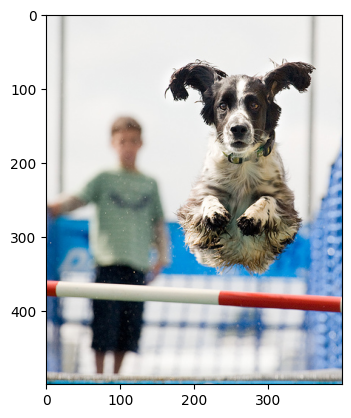

1/1 [==============================] - 0s 13ms/step
Greedy Search: dog running


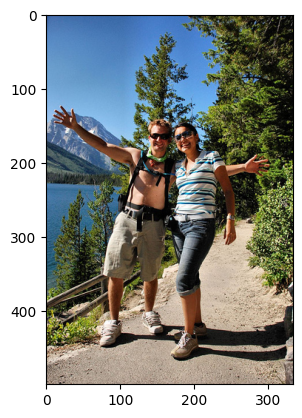

1/1 [==============================] - 0s 13ms/step
Greedy Search: two girls play


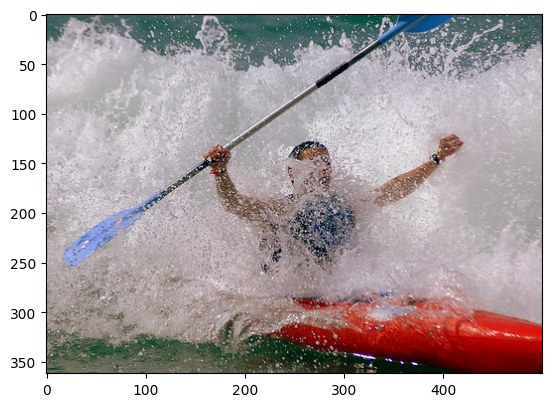

1/1 [==============================] - 0s 13ms/step
Greedy Search: two dogs running


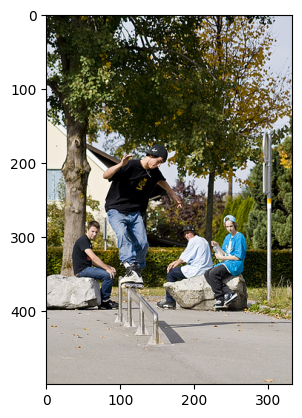

1/1 [==============================] - 0s 16ms/step
Greedy Search: two people stand


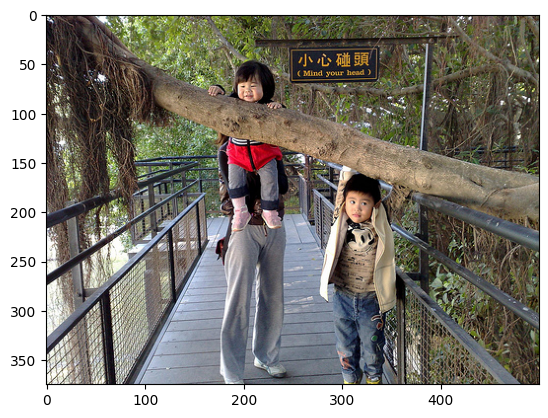

1/1 [==============================] - 0s 15ms/step
Greedy Search: man standing front


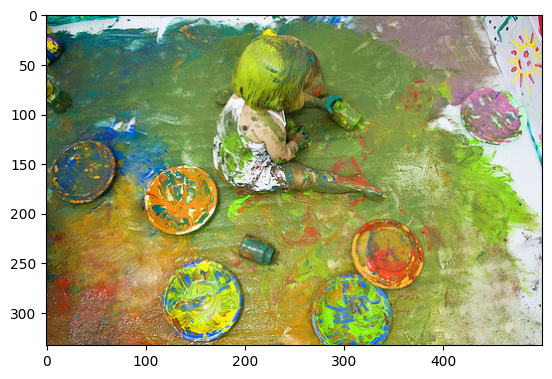

1/1 [==============================] - 0s 13ms/step
Greedy Search: two men standing


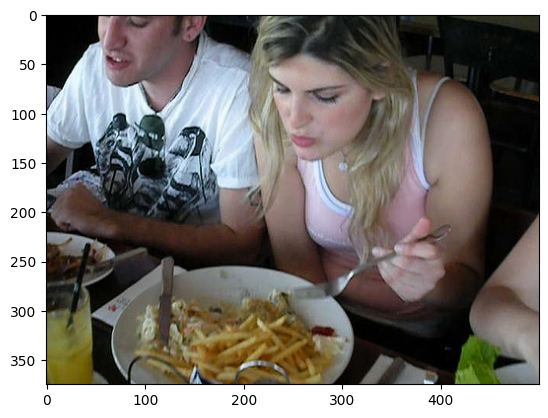

1/1 [==============================] - 0s 12ms/step
Greedy Search: two young women standing


KeyboardInterrupt: 

In [29]:
for i in encoding_train:
    pic=i
    image = encoding_train[pic].reshape((1,4096))
    x=plt.imread(f'{os.getcwd()}/images/{pic}.jpg')
    plt.imshow(x)
    plt.show()


    def greedy_search(pic):
        start = 'startseq'
        for i in range(max_length):
            seq = [wordtoix[word] for word in start.split() if word in wordtoix]
            seq = pad_sequences([seq], maxlen = max_length)
            yhat = model.predict([pic, seq])
            yhat = np.argmax(yhat)
            word = ixtoword[yhat]
            start += ' ' + word
            if word == 'endseq':
                break
        final = start.split()
        final = final[1:-1]
        final = ' '.join(final)
        return final

    print("Greedy Search:",greedy_search(np.array(image)))

In [28]:
from nltk.translate.bleu_score import sentence_bleu
reference = [i.split() for i in descriptions[pic]]
candidate = greedy_search(np.array(image)).split()

print('Individual 1-gram: %f' % sentence_bleu(reference, candidate, weights=(1, 0, 0, 0)))
print('Individual 2-gram: %f' % sentence_bleu(reference, candidate, weights=(0, 1, 0, 0)))
print('Individual 3-gram: %f' % sentence_bleu(reference, candidate, weights=(0, 0, 1, 0)))
print('Individual 4-gram: %f' % sentence_bleu(reference, candidate, weights=(0, 0, 0, 1)))

1/1 [==============================] - 0s 14ms/step
Individual 1-gram: 0.142857
Individual 2-gram: 0.000000
Individual 3-gram: 0.000000
Individual 4-gram: 0.000000


/opt/homebrew/lib/python3.10/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/homebrew/lib/python3.10/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/homebrew/lib/python3.10/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnin